# Predicting Apartment Prices in Barcelona 2023

Submission for Computational Machine Learning Project 1 - Predicting Apartment Prices in Barcelona

Team: Les Corts

Team members: Vanessa Kromm, Oliver Gatland, Angelo Di Gianvito, Hangze Wu

Notebook layout:

1. Exploratory Data Analysis
2. Data Cleaning and Imputing
3. Cross validation and prediction
4. Annex - Methods that didn't improve the score


## Libraries and data import

### Library import

In [1]:
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

### Data import

In [14]:
# Setting data paths
train_data_path = "./data/train.csv"
test_data_path = "./data/test.csv"

# Reading CSV files
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

# Creating column to differentiate df_test and df_train
df_train['train_dummy'] = 1
df_test['train_dummy'] = 0

# Merging dataframes
df = pd.concat([df_train, df_test], axis=0).sort_values("id").reset_index()

## Exploratory Data Analysis

### Initial exploration

In [3]:
# Display the dataframe
display(df)

,index,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets,price,train_dummy
0,597,1,3.0,3.0,126.0,east,2009.0,6º - 4a,True,True,Sant Martí,9.0,True,True,NaN,NaN,0
1,6521,2,4.0,3.0,154.0,NaN,2008.0,2º - 2a,True,True,Horta,0.0,True,True,NaN,1348.0,1
2,3404,3,1.0,3.0,140.0,NaN,2000.0,4º - 4a,False,True,Sants,6.0,NaN,False,NaN,1285.0,1
3,481,4,3.0,2.0,50.0,south,1984.0,1º - 2a,False,False,Sant Andreu,0.0,False,False,NaN,NaN,0
4,7628,5,3.0,3.0,106.0,south,1959.0,4º - 2a,True,True,Gràcia,1.0,True,True,NaN,1156.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3983,9996,4.0,3.0,51.0,west,1972.0,4º - 4a,False,False,Nou Barris,3.0,False,True,2.0,875.0,1
9996,1028,9997,3.0,3.0,134.0,NaN,1994.0,5º - 2a,False,False,Ciutat Vella,0.0,True,False,3.0,1108.0,1
9997,6572,9998,2.0,1.0,83.0,south,1950.0,9º - 4a,False,False,Les Cors,0.0,True,True,NaN,1083.0,1
9998,1767,9999,2.0,2.0,76.0,west,1998.0,1º - 2a,False,False,Nou Barris,4.0,True,True,3.0,NaN,0


In [4]:
# Data Exploration

# Dataframe shape and variable types
shape = df.shape
print(f"The Dataframe has a shape of {shape[0]} rows and {shape[1]} columns.")
var_types=df.dtypes
print(f"\nThe variable types of the Dataframe are the following:")
display(var_types)

# Descriptive stats
print(f"\nThe descriptives of the Dataframe are the following:")
describe_df = df.describe()
display(describe_df)

The Dataframe has a shape of 10000 rows and 17 columns.

The variable types of the Dataframe are the following:


index                 int64
id                    int64
num_rooms           float64
num_baths           float64
square_meters       float64
orientation          object
year_built          float64
door                 object
is_furnished         object
has_pool             object
neighborhood         object
num_crimes          float64
has_ac               object
accepts_pets         object
num_supermarkets    float64
price               float64
train_dummy           int64
dtype: object


The descriptives of the Dataframe are the following:


,index,id,num_rooms,num_baths,square_meters,year_built,num_crimes,num_supermarkets,price,train_dummy
count,10000.000000,10000.00000,9809.000000,9800.000000,9802.000000,9800.000000,9800.000000,1785.000000,8000.000000,10000.00000
mean,3399.500000,5000.50000,3.175553,1.992449,108.104673,1985.358163,2.776122,1.984314,1099.616250,0.80000
std,2402.896303,2886.89568,7.067345,0.815294,38.442532,20.613132,3.436340,0.804124,271.686617,0.40002
min,0.000000,1.00000,1.000000,1.000000,-100.000000,1950.000000,0.000000,1.000000,195.000000,0.00000
25%,1249.750000,2500.75000,1.000000,1.000000,78.000000,1968.000000,0.000000,1.000000,905.750000,1.00000
50%,2999.500000,5000.50000,3.000000,2.000000,109.000000,1985.000000,1.000000,2.000000,1104.000000,1.00000
75%,5499.250000,7500.25000,4.000000,3.000000,139.750000,2003.000000,6.000000,3.000000,1295.000000,1.00000
max,7999.000000,10000.00000,99.000000,3.000000,170.000000,2021.000000,10.000000,3.000000,2095.000000,1.00000


In [42]:
# Investigating missing values
print(df.isna().sum())
print(df.isna().mean())

index                           0
id                              0
num_rooms                       0
num_baths                       0
square_meters                   0
year_built                      0
is_furnished                    0
has_pool                        0
num_crimes                      0
has_ac                          0
accepts_pets                    0
price                        2000
train_dummy                     0
floor                           0
orient_east                     0
orient_north                    0
orient_south                    0
orient_west                     0
neigh_Ciutat Vella              0
neigh_Eixample                  0
neigh_Gràcia                    0
neigh_Horta                     0
neigh_Les Cors                  0
neigh_Nou Barris                0
neigh_Sant Andreu               0
neigh_Sant Martí                0
neigh_Sants                     0
neigh_Sarrià-Sant Gervasi       0
dtype: int64
index                        0.0
id

### Looking at outliers 

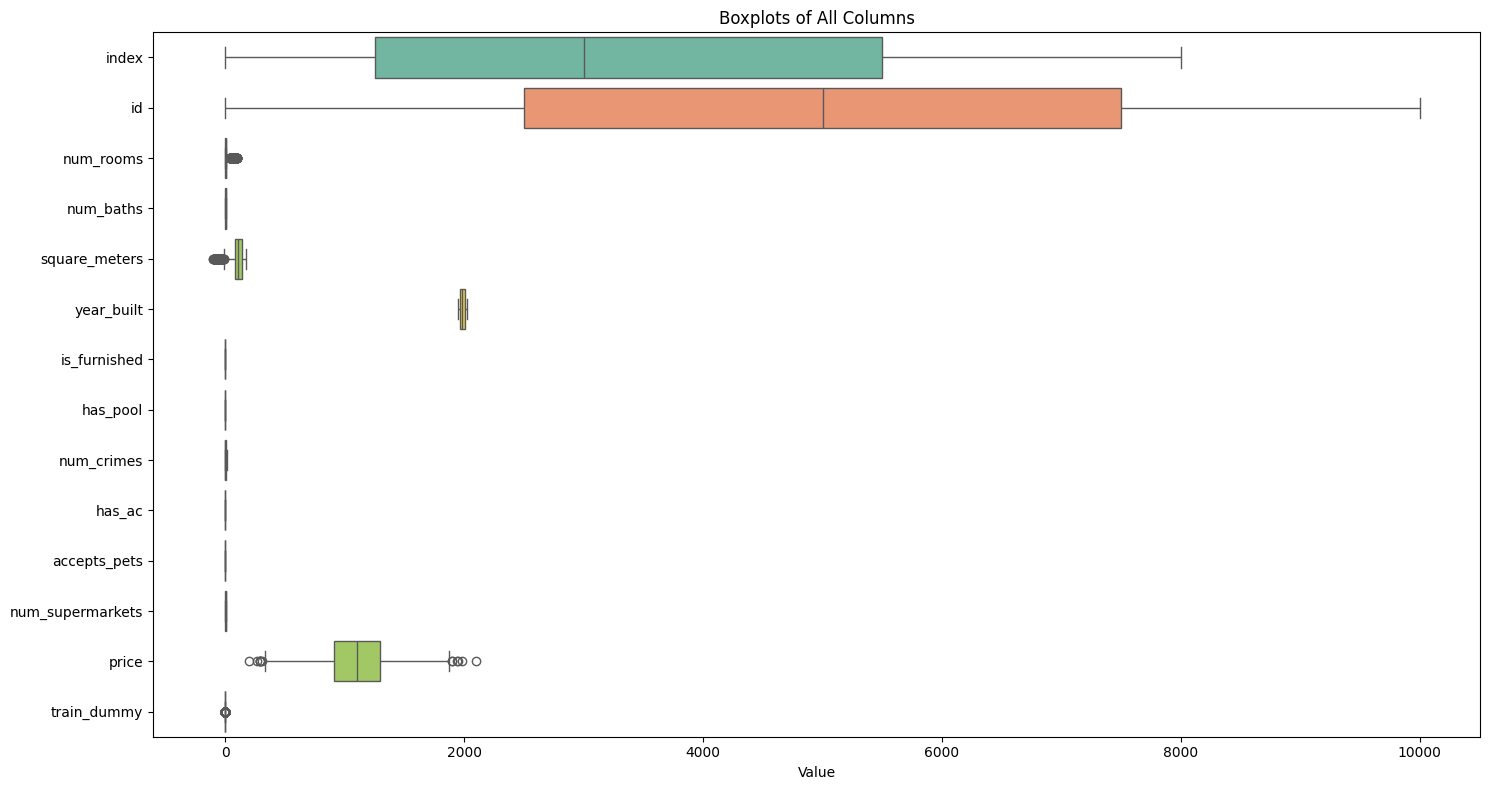

In [6]:
# Look at outlier distribution for all variables
plt.figure(figsize=(15, 8))

sns.boxplot(data=df, orient="h", palette="Set2")
plt.title("Boxplots of All Columns")
plt.xlabel("Value")

plt.tight_layout()

# Show the plot
plt.show()

The above plot is hard to interpret due to the different scales across variables. Below we create subplots to investigate each variable more precisely.

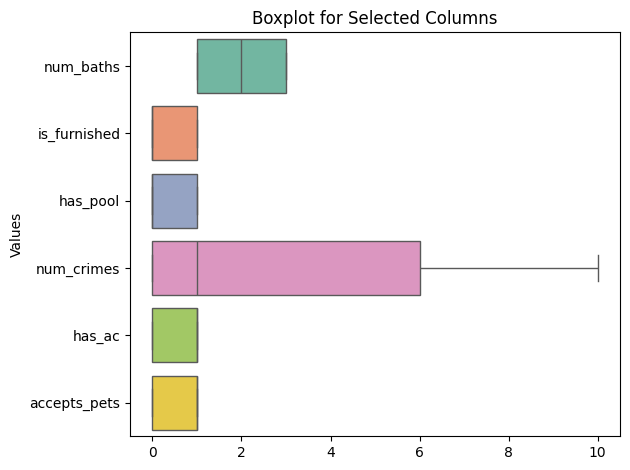

In [7]:
# Select the columns you want to include in the boxplot
selected_columns = ['num_baths', 'is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets']


sns.boxplot(data=df[selected_columns], orient="h", palette="Set2")

plt.title("Boxplot for Selected Columns")
plt.ylabel("Values")

plt.tight_layout()

# Show the plot
plt.show()

no outliers in num_baths, is_furnished, has_pool, num_crimes, has_ac, accepts_pets

C:\Users\gatla\AppData\Local\Temp\ipykernel_1732\548839294.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df['num_rooms'], palette="Set2")


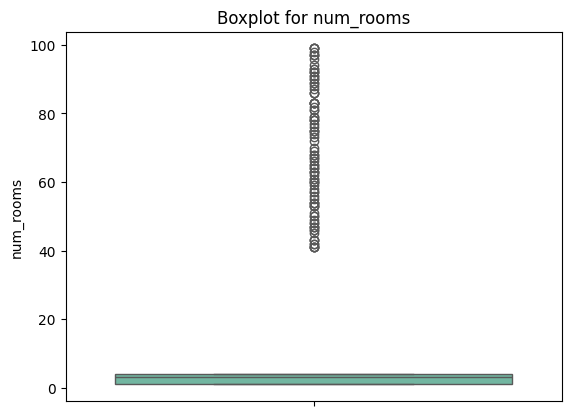

In [8]:
sns.boxplot(data=df['num_rooms'], palette="Set2")
plt.title("Boxplot for num_rooms")

# Show the plot
plt.show()

outliers in column num_rooms (as visivle in plot when num_rooms > 10)

C:\Users\gatla\AppData\Local\Temp\ipykernel_1732\1224323043.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df['square_meters'], palette="Set2")


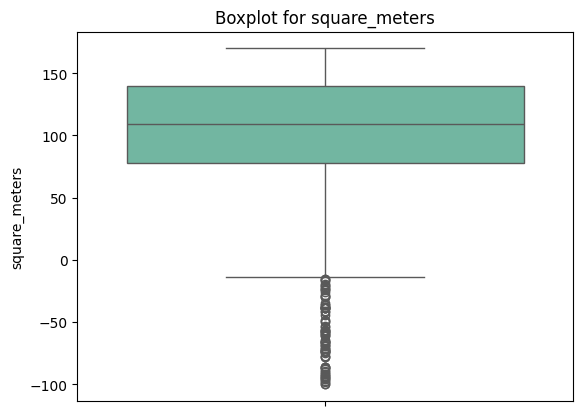

In [9]:
sns.boxplot(data=df['square_meters'], palette="Set2")
plt.title("Boxplot for square_meters")

# Show the plot
plt.show()

outliers in column square_meters: values < 0 (generally negative values fpr square meters make no sense)

C:\Users\gatla\AppData\Local\Temp\ipykernel_1732\3415170931.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df['year_built'], palette="Set2")


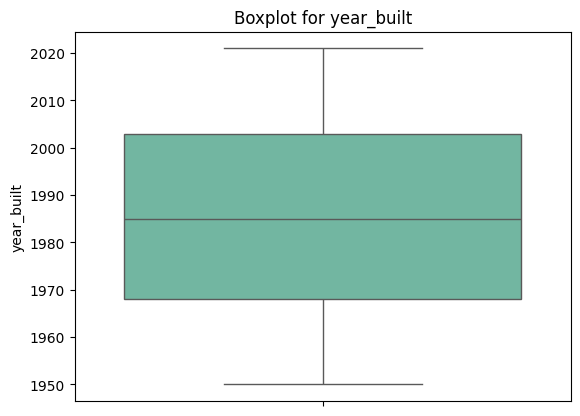

In [10]:
sns.boxplot(data=df['year_built'], palette="Set2")
plt.title("Boxplot for year_built")

# Show the plot
plt.show()

no outliers for year_built

### Correlations

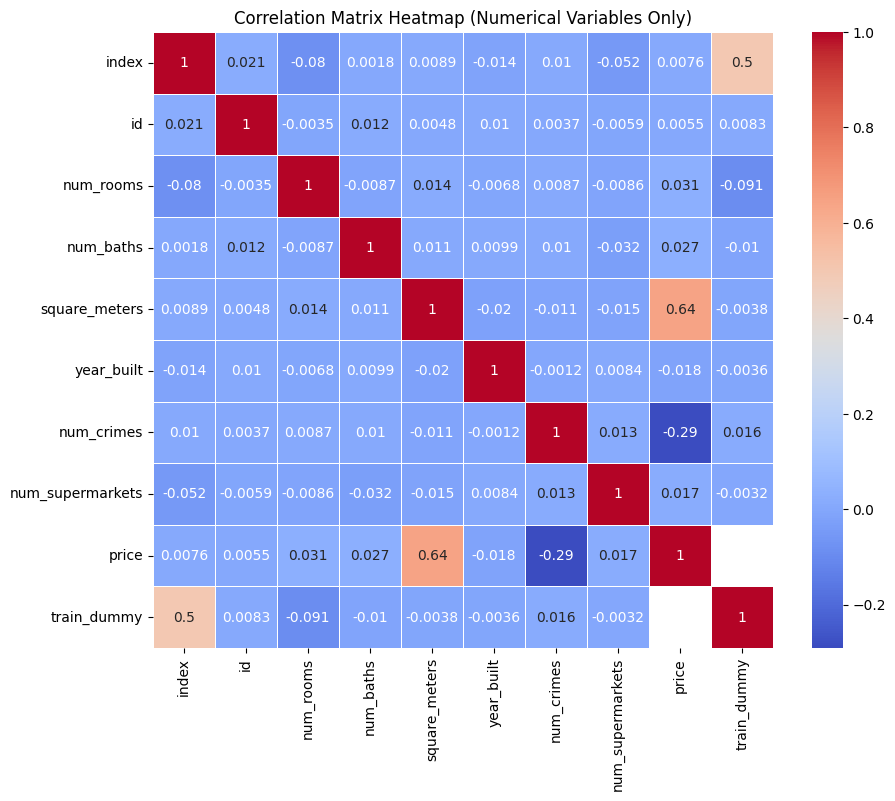

In [11]:
numerical_columns = df.select_dtypes(include=['number'])
correlation_matrix = numerical_columns.corr()

# Create a heatmap
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap (Numerical Variables Only)")
plt.show()

Looking at the above matrix, we can see that square meters appears to be the most correlated with price, followed by num_crimes. The other variables do not have a strong correlation with price (although this does not mean they will not be useful for prediction), and there doesn't appear to be much collinearity between the variables we will be using for prediction.

## Data cleaning
- Creating Floor 1 Dummy
- Removing outliers from the num_rooms and square_meters
- imputing missing values
- encoding categorical variables neighborhood and orientation

In [15]:
print(df['orientation'].value_counts())
# change orientation 'soxth' to 'south'
df['orientation'].replace('soxth', 'south')

print(df['orientation'].isna().sum())
# Missing values need to be filled, KNN only works with numerical values -> map orientations to numbers for KNN

def convert_orientation(orientation):
    mapping = {"north": 1, "east": 2, "south": 3, "west": 4}
    
    if pd.notna(orientation):
        return mapping.get(orientation) 
    else:
        return np.nan


# Map the function to the 'Direction' column to create a new column with numerical values
df['orientation'] = df['orientation'].map(convert_orientation)


orientation
west     1831
north    1787
south    1768
east     1749
soxth       1
Name: count, dtype: int64
2864


In [16]:
# Creating numerical floor variable
df['floor'] = df['door'].str.extract(r'(\d+)º').astype(float)
# Dropping door and door_num columns (justification: door number unlikely to be a good predictor for house prices)
df.drop('door', axis=1, inplace=True)


# Replacing the outliers with NaN in the number of rooms (justify cutoff value: outliers are very high above 10, see graph above)
df['num_rooms'] = df['num_rooms'].apply(lambda x: x if x<10 else np.nan)

# Replacing the values of square metres < 0 with NaN (justify cutoff value: outliers for values below 0, see graph above)
df.loc[df['square_meters'] < 0, 'square_meters'] = np.nan

### KNN imputing

In [17]:
# Standardization and KNN imputing
def imputing_missing(impute_df, vars_to_impute):
    standardizer = StandardScaler()
    impute_df[vars_to_impute] = standardizer.fit_transform(df[vars_to_impute])
    imputer = KNNImputer(n_neighbors=7)
    impute_df[vars_to_impute] = imputer.fit_transform(df[vars_to_impute])
    impute_df[vars_to_impute] = standardizer.inverse_transform(df[vars_to_impute])
    return impute_df

vars_to_impute = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'num_crimes', 'floor', 'has_ac', 'accepts_pets', 'is_furnished', 'has_pool', 'orientation']
df = imputing_missing(df, vars_to_impute)

In [18]:
# Re-standardising variables we want standardised for the modelling
to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'num_crimes']
standardizer = StandardScaler()
standardize_df = pd.DataFrame() 
standardize_df[to_standardize] = standardizer.fit_transform(df[to_standardize])

for col in to_standardize:
    df[col] = standardize_df[col]

In [20]:
# Transforming column orientation by one_hot_encoding to get rid of current ordinality for price prediction
print(df['orientation'].value_counts())

# Round values to get "categories" back (KNN process has imputed non-whole numbers)
df['orientation'] = round(df['orientation'],0)

# Remapping for easier One-hot-encoding
mapping = {1: "north", 2: "east", 3: "south", 4:"west"}

df['orientation'] = [mapping[value] for value in df['orientation']]

df = pd.get_dummies(df, columns=['orientation'], prefix=['orient']).reset_index(drop=True)

orientation
3.000000    1992
2.000000    1945
4.000000    1831
1.000000    1787
2.571429     336
2.285714     333
2.714286     311
2.142857     291
2.857143     254
2.428571     244
1.857143     134
3.142857     125
2.428571     109
3.285714      85
1.714286      72
3.571429      21
1.571429      19
3.428571      18
3.428571      14
2.571429      12
1.571429      11
2.857143      11
1.428571       9
3.142857       9
1.857143       7
2.714286       5
3.714286       5
2.142857       3
1.714286       2
1.285714       2
1.000000       1
1.285714       1
1.142857       1
Name: count, dtype: int64


### Imputing neighborhood based on the number of crimes

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Sant Martí'),
  Text(1, 0, 'Horta'),
  Text(2, 0, 'Sants'),
  Text(3, 0, 'Sant Andreu'),
  Text(4, 0, 'Gràcia'),
  Text(5, 0, 'Eixample'),
  Text(6, 0, 'Ciutat Vella'),
  Text(7, 0, 'Sarrià-Sant Gervasi'),
  Text(8, 0, 'Les Cors'),
  Text(9, 0, 'Nou Barris')])

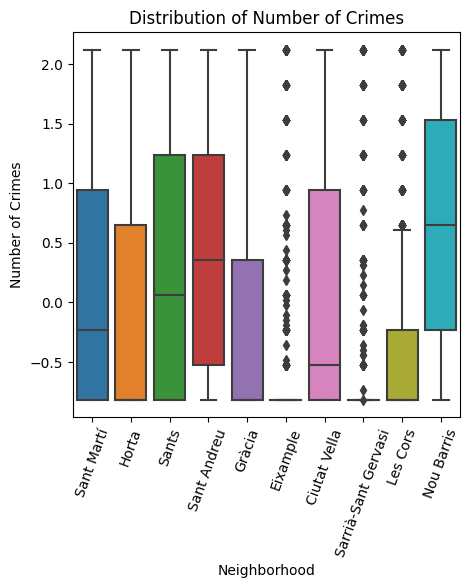

In [21]:
# 200 missing values in neighborhood need to be filled. Investigate if neighborhoods differ by num_crimes
plt.figure(figsize=(5, 5))
sns.boxplot(data = df, x ='neighborhood', y = 'num_crimes')
plt.title('Distribution of Number of Crimes')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=70)

In [22]:
# There are large differences in the mean number of crimes per neighborhood, so we fill the NaN values with the mean for the neighborhood.
crimes_by_neighborhood = df.groupby('neighborhood')['num_crimes'].mean().to_dict()

# Function to be used in the imputation process
def find_closest_key(target, dictionary):
    closest_key = None
    closest_difference = float('inf')

    for key, value in dictionary.items():
        difference = abs(target - value)
        if difference < closest_difference:
            closest_key = key
            closest_difference = difference

    return closest_key

# Imputing neighborhood based on number of crimes
def impute_neighborhood(row):
    crimes = row['num_crimes']
    neighborhood = row['neighborhood']
    if pd.isnull(neighborhood):
        return find_closest_key(crimes, crimes_by_neighborhood)
    else:
        return neighborhood
    
df['neighborhood'] = df.apply(impute_neighborhood, axis=1)

### Handeling the num_supermarkets column

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Sant Martí'),
  Text(1, 0, 'Horta'),
  Text(2, 0, 'Sants'),
  Text(3, 0, 'Sant Andreu'),
  Text(4, 0, 'Gràcia'),
  Text(5, 0, 'Eixample'),
  Text(6, 0, 'Ciutat Vella'),
  Text(7, 0, 'Sarrià-Sant Gervasi'),
  Text(8, 0, 'Les Cors'),
  Text(9, 0, 'Nou Barris')])

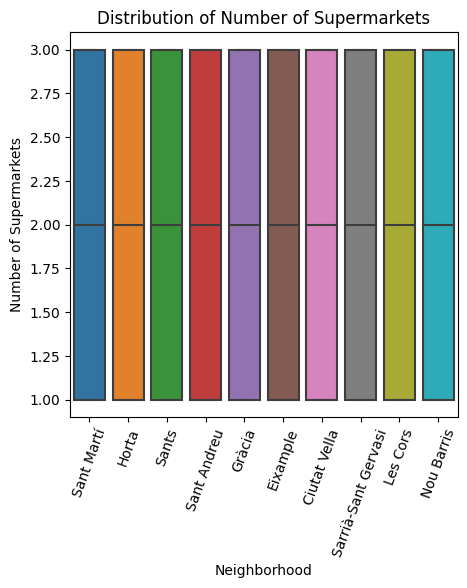

In [23]:
# first thought: number of supermarkets may depend on the neighborhood

plt.figure(figsize=(5, 5))
sns.boxplot(data = df, x ='neighborhood', y = 'num_supermarkets')
plt.title('Distribution of Number of Supermarkets')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Supermarkets')
plt.xticks(rotation=70)

we were thinking about mean per neighborhood, but all are very similiar -> drop the columns because approx. 80% missing values

In [24]:
# drop column num_supermarkets

df.drop(['num_supermarkets'], axis=1, inplace=True)

### Closer look at floors

In [25]:
# After KNN there are also floats for 'floor' so we convert these to integers
df['floor'] = round(df['floor'],0)

floor
1.0     1056.926531
2.0     1051.942172
3.0     1065.078283
4.0     1091.747170
5.0     1089.327626
6.0     1113.609840
7.0     1128.796818
8.0     1122.762452
9.0     1132.267399
10.0    1133.197500
Name: price, dtype: float64


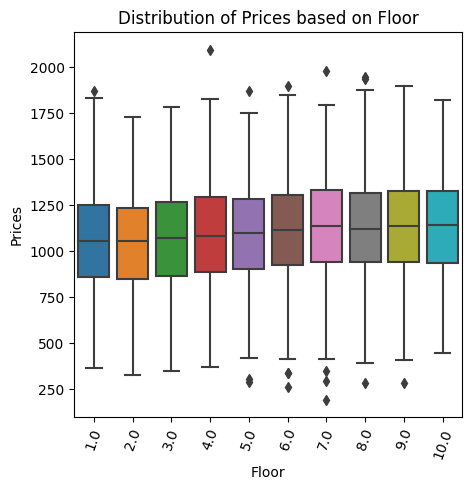

In [26]:
# Looking at prices based on the floor
plt.figure(figsize=(5, 5))
sns.boxplot(data = df, x ='floor', y = 'price')
plt.title('Distribution of Prices based on Floor')
plt.xlabel('Floor')
plt.ylabel('Prices')
plt.xticks(rotation=70)

price_floor = df.groupby('floor')['price'].mean()
print(price_floor)

### Encode column neighborhood

In [27]:
df = pd.get_dummies(df, columns=['neighborhood'], prefix=['neigh']).reset_index(drop=True)

In [28]:
# Check that all missing values are handeled before modelling
df.isna().sum()

index                           0
id                              0
num_rooms                       0
num_baths                       0
square_meters                   0
year_built                      0
is_furnished                    0
has_pool                        0
num_crimes                      0
has_ac                          0
accepts_pets                    0
price                        2000
train_dummy                     0
floor                           0
orient_east                     0
orient_north                    0
orient_south                    0
orient_west                     0
neigh_Ciutat Vella              0
neigh_Eixample                  0
neigh_Gràcia                    0
neigh_Horta                     0
neigh_Les Cors                  0
neigh_Nou Barris                0
neigh_Sant Andreu               0
neigh_Sant Martí                0
neigh_Sants                     0
neigh_Sarrià-Sant Gervasi       0
dtype: int64

### Seperating the dfs for training and testing

In [29]:
# Seperating test and train
X_train = df[df['train_dummy'] == 1][['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'is_furnished', 'has_pool', 'has_ac', 'accepts_pets', 'orient_north' , 'orient_east', 'orient_south', 'orient_west']]
y_train = df[df['train_dummy'] == 1][['price']]

X_test = df[df['train_dummy'] == 0][['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'is_furnished', 'has_pool', 'has_ac', 'accepts_pets', 'orient_north' , 'orient_east', 'orient_south', 'orient_west']]

## Model Training and Cross Validation

In [30]:
# Creating function for cross validation
def prediction_accuracy(X_train, y_train, model):
    mse_list = []
    num_of_predictions = 1000
    for i in range (num_of_predictions):
        X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, test_size= 0.2)

        model.fit(X_train_temp, y_train_temp)

        y_pred = model.predict(X_test_temp)
        mse = mean_squared_error(y_test_temp, y_pred)
        mse_list.append(mse)
    return sum(mse_list) / len(mse_list)


In [31]:
# Test linear regression model
lin_model = LinearRegression()
print(prediction_accuracy(X_train, y_train, lin_model))

29408.717400180554


In [32]:
# Predicting prices with linear regression model
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

In [33]:
# Displaying regression coefficients from the linear model
feature_names = X_train.columns
feature_values = lin_model.coef_

linear_coeff = pd.DataFrame(feature_values, columns=feature_names)

# Transpose the DataFrame to have feature names as the index and values as columns
linear_coeff = linear_coeff.transpose()
linear_coeff.columns = ['Value']
linear_coeff['Value'] = linear_coeff['Value'].apply(lambda x: '{:.2f}'.format(x))

# Print the DataFrame
print(linear_coeff)

                            Value
num_rooms                   15.96
num_baths                    8.10
square_meters              192.62
year_built                  -1.17
floor                       10.29
num_crimes                 -74.83
neigh_Ciutat Vella           1.52
neigh_Eixample               3.59
neigh_Gràcia                 3.33
neigh_Horta                  0.87
neigh_Les Cors               3.17
neigh_Nou Barris             0.53
neigh_Sant Andreu           -4.62
neigh_Sant Martí            -4.92
neigh_Sants                 -3.67
neigh_Sarrià-Sant Gervasi    0.21
is_furnished                 1.53
has_pool                     6.91
has_ac                       8.25
accepts_pets                -2.31
orient_north                 0.00
orient_east                  1.24
orient_south                -1.69
orient_west                  0.45


In [36]:
# Finding optimal alpha values for LASSO and Ridge regressions

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, test_size= 0.2, random_state=42)

# Define a range of alpha values to try
alphas = np.logspace(-10, 0, 50)

# Initialize variables to store the best alpha and minimum MSE
best_alpha_lasso = None
best_alpha_ridge = None
min_mse_lasso = float('inf')
min_mse_ridge = float('inf')

# Loop over the alpha values and fit Lasso and Ridge models
for alpha in alphas:
    # Fit Lasso model
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_temp, y_train_temp)
    y_pred_lasso = lasso.predict(X_test_temp)
    mse_lasso = mean_squared_error(y_test_temp, y_pred_lasso)

    # Update best alpha and minimum MSE for Lasso
    if mse_lasso < min_mse_lasso:
        min_mse_lasso = mse_lasso
        best_alpha_lasso = alpha

    # Fit Ridge model
    ridge = Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(X_train_temp, y_train_temp)
    y_pred_ridge = ridge.predict(X_test_temp)
    mse_ridge = mean_squared_error(y_test_temp, y_pred_ridge)

    # Update best alpha and minimum MSE for Ridge
    if mse_ridge < min_mse_ridge:
        min_mse_ridge = mse_ridge
        best_alpha_ridge = alpha

# Print the best alpha and minimum MSE for Lasso and Ridge
print("Best alpha for Lasso:", round(best_alpha_lasso,3))
print()
print("Best alpha for Ridge:", round(best_alpha_ridge,3))



C:\Users\vanes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.484e+06, tolerance: 4.713e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.484e+06, tolerance: 4.713e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\vanes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\loca

Best alpha for Lasso: 1.0

Best alpha for Ridge: 1.0


In [37]:
# Test LASSO regression model with best alpha
lasso_model = Lasso(alpha=best_alpha_lasso)
print(prediction_accuracy(X_train, y_train, lasso_model))

29366.93641676218


In [38]:
# Predicting prices with LASSO regression model
lasso_model.fit(X_train, y_train)
y_pred_LASSO = lasso_model.predict(X_test)

In [39]:
# Displaying regressio coefficients for LASSO model
print("Lasso Coefficients:")
for feature, coefficient in zip(X_train.columns, lasso_model.coef_):
    print(feature, ":", round(coefficient,2))

Lasso Coefficients:
num_rooms : 15.0
num_baths : 7.08
square_meters : 191.54
year_built : -0.21
floor : 10.14
num_crimes : -74.6
neigh_Ciutat Vella : 0.0
neigh_Eixample : 0.0
neigh_Gràcia : 0.0
neigh_Horta : 0.0
neigh_Les Cors : 0.0
neigh_Nou Barris : 0.0
neigh_Sant Andreu : -0.0
neigh_Sant Martí : -0.0
neigh_Sants : -0.0
neigh_Sarrià-Sant Gervasi : 0.0
is_furnished : 0.0
has_pool : 2.84
has_ac : 4.16
accepts_pets : -0.0
orient_north : 0.0
orient_east : 0.0
orient_south : -0.0
orient_west : 0.0


In [40]:
# Test Ridge regression model with best alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
print(prediction_accuracy(X_train, y_train, ridge_model))

29474.59260421304


In [41]:
# Predicting prices with Ridge regression model
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

In [42]:
# Displaying regression coefficients for Ridge model
feature_names = X_train.columns
feature_values = ridge_model.coef_

ridge_coeff = pd.DataFrame(feature_values, columns=feature_names)

# Transpose the DataFrame to have feature names as the index and values as columns
ridge_coeff = ridge_coeff.transpose()
ridge_coeff.columns = ['Value']
ridge_coeff['Value'] = ridge_coeff['Value'].apply(lambda x: '{:.2f}'.format(x))

# Print the DataFrame
print(ridge_coeff)

                            Value
num_rooms                   15.96
num_baths                    8.09
square_meters              192.60
year_built                  -1.17
floor                       10.29
num_crimes                 -74.82
neigh_Ciutat Vella           1.52
neigh_Eixample               3.59
neigh_Gràcia                 3.33
neigh_Horta                  0.87
neigh_Les Cors               3.17
neigh_Nou Barris             0.52
neigh_Sant Andreu           -4.62
neigh_Sant Martí            -4.92
neigh_Sants                 -3.67
neigh_Sarrià-Sant Gervasi    0.21
is_furnished                 1.53
has_pool                     6.91
has_ac                       8.24
accepts_pets                -2.31
orient_north                 0.00
orient_east                  1.23
orient_south                -1.68
orient_west                  0.45


As you can see, the cross validation shows that the Lasso regression has the lowest MSE score, followed by linear regression and ridge which has the highest MSE.
By looking at the coefficients you can clearly see that Lasso solved the collinearity between the features by seeting some of the coefficents to 0. These include all neighborhood variables except for Sant Marti. Probably because of the collinearity between neighborhood and num_crimes since we imputed the missing values in neighborhood based on that. Also all the variables for orientation are set to 0 now, as well as is_furnished.
Based on the coefficients you can say that square_meters has the highest impact on the apartment price, followed by num_crimes which has a negative effect. 

### Exporting best prediction

In [43]:
pred_df = pd.DataFrame()
pred_df['id'] = df[df['train_dummy'] == 0]['id']
pred_df['pred'] = y_pred_LASSO

# Insert export file path below
export_data_path = 'C:/Users/vanes/Desktop/BSE/Term 1/Computational Machine Learning/check_before_submitting.csv'
pred_df.to_csv(export_data_path, index=False)

## Annex - Methods that didn't improve the score

#### using mean of year_built to impute NAs instead of KNN

In [ ]:
# looking at year built
df['year_built'].hist()
plt.show()

# quite equally distributed
# look whether there are differences based on neighborhood
mean_year_per_neigh = df.groupby('neighborhood')['year_built'].mean()
print(mean_year_per_neigh)
# no differences, just impute mean of year built
df['year_built'] = df['year_built'].fillna(df['year_built'].mean())

#### changing the number of rooms for those with outliers in sqm_per_room

In [ ]:
mean_sqm_to_room = df.groupby('num_rooms')['square_meters'].mean()
print(mean_sqm_to_room)

# seems odd that the mean size of the apartments is nearly the same for all num_rooms
# creating a new variable: square meters per room and look at the outliers (only if square_meter is positive, closer look at negative values later)
def calculating_sqm_per_room(row):
    if row['square_meters'] > 0:
        return row['square_meters']/ row['num_rooms']
    else:
        row['sqm_per_room'] = pd.NA    
df['sqm_per_room'] = df.apply(calculating_sqm_per_room, axis=1)
sns.boxplot(data=df['sqm_per_room'], palette="Set2")
plt.show()

# outliers detected from boxplot, take a closer look

upper_bound = 100
print(upper_bound)
df[df['sqm_per_room']>upper_bound]['num_rooms'].value_counts()

# nearly all rows that have an outlier as sqm_per_room have only 1 room. This doesn't make sense. Change this data with mean of sqm_per_room of non outliers

median_sqm_per_room = df[df['sqm_per_room'] < upper_bound]['sqm_per_room'].median()
print(median_sqm_per_room)

def changing_num_rooms_in_outliers(row):
    if row['square_meters'] >0 and pd.notna(row['num_rooms']):
        if row['sqm_per_room'] < upper_bound:
            return row['num_rooms']
        else:
            return round(row['square_meters'] / median_sqm_per_room,0)
    else:
        return row['num_rooms']    
    
df['num_rooms'] = df.apply(changing_num_rooms_in_outliers, axis=1)

#### imputing binary variables with logistic regressions for each column

In [ ]:
# imputing binary variables with logistic regression

correlation_matrix = df.corr(method='pearson')

# Calculate the correlation of all columns with respect to the 'price' column
price_correlation = correlation_matrix['price']

price_correlation = price_correlation.drop('price')
plt.figure(figsize=(12, 8))
sns.heatmap(price_correlation.to_frame(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.show         

#order do impute (from lowest to highest correlation): has_pool, is_furnished, has_ac, accepts_pets

# imputing has_pool
df['has_pool'] = df['has_pool'].map({True: 1, False: 0})
df_train = df[df['has_pool'].notna()]
df_test = df[df['has_pool'].isna()]
X_train = df_train[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi']]
y_train = df_train['has_pool']
X_test = df_test[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi']]

# Create an instance of the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the data
logreg.fit(X_train, y_train)

# Predict the class labels
predicted_labels = logreg.predict(X_test)
df.loc[df['has_pool'].isna(), 'has_pool'] = predicted_labels


# imputing is_furnished
df['is_furnished'] = df['is_furnished'].map({True: 1, False: 0})
df_train = df[df['is_furnished'].notna()]
df_test = df[df['is_furnished'].isna()]
X_train = df_train[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool']]
y_train = df_train['is_furnished']
X_test = df_test[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool']]

# Create an instance of the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the data
logreg.fit(X_train, y_train)

# Predict the class labels
predicted_labels = logreg.predict(X_test)
df.loc[df['is_furnished'].isna(), 'is_furnished'] = predicted_labels


# imputing has_ac
df['has_ac'] = df['has_ac'].map({True: 1, False: 0})
df_train = df[df['has_ac'].notna()]
df_test = df[df['has_ac'].isna()]
X_train = df_train[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool', 'is_furnished']]
y_train = df_train['has_ac']
X_test = df_test[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool', 'is_furnished']]

# Create an instance of the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the data
logreg.fit(X_train, y_train)

# Predict the class labels
predicted_labels = logreg.predict(X_test)
df.loc[df['has_ac'].isna(), 'has_ac'] = predicted_labels


# imputing has_ac
df['accepts_pets'] = df['accepts_pets'].map({True: 1, False: 0})
df_train = df[df['accepts_pets'].notna()]
df_test = df[df['accepts_pets'].isna()]
X_train = df_train[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool', 'is_furnished', 'has_ac']]
y_train = df_train['accepts_pets']
X_test = df_test[['num_rooms', 'num_baths', 'square_meters', 'year_built', 'floor', 'num_crimes', 'num_supermarkets','neigh_Ciutat Vella', 'neigh_Eixample', 'neigh_Gràcia', 'neigh_Horta', 'neigh_Les Cors', 'neigh_Nou Barris', 'neigh_Sant Andreu', 'neigh_Sant Martí', 'neigh_Sants', 'neigh_Sarrià-Sant Gervasi', 'has_pool', 'is_furnished', 'has_ac']]

# Create an instance of the Logistic Regression model
logreg = LogisticRegression()

# Fit the model to the data
logreg.fit(X_train, y_train)

# Predict the class labels
predicted_labels = logreg.predict(X_test)
df.loc[df['accepts_pets'].isna(), 'accepts_pets'] = predicted_labels

With imputing binary variables with logistic regression instead of KNN: MSE score increases to 30076.70033997275

-> better to use KNN

#### Winsorizing the outliers in price: only reduced MSE in traindata, MSE in kaggle was increased -> overfitting!

In [ ]:
# Windsorizing price outliers in train data
def winsorize(data, limits=(0.05, 0.05)):
    """
    Winsorize a dataset by replacing extreme values with less extreme values.

    Arguments:
    - data: 1-D array or list, the dataset to be winsorized.
    - limits: Tuple of two floats (lower, upper), representing the fraction of values to be replaced
              on each tail. Default is (0.05, 0.05), which replaces 5% of the values on each tail.

    Returns:
    - winsorized_data: 1-D array, the winsorized dataset.
    """
    # Copy the input data to avoid modifying the original array
    winsorized_data = np.copy(data)


    # Calculating the lower and upper limits for winsorization
    lower_limit = np.percentile(winsorized_data, limits[0] * 100)
    upper_limit = np.percentile(winsorized_data, 100 - limits[1] * 100)

    print('Lower limit:', lower_limit)
    print('Upper limit:', upper_limit)

    # Replacing values below the lower limit with the lower limit
    winsorized_data[winsorized_data < lower_limit] = lower_limit

    # Replacing values above the upper limit with the upper limit
    winsorized_data[winsorized_data > upper_limit] = upper_limit

    return winsorized_data

# Windsorizing the price variable
df_train['price'] = winsorize(df_train['price'].dropna(), limits=(0.05, 0.05))

#### feature engineering: creating the column 'sqm_per_room'

In [ ]:
df['sqm_per_room'] = df['square_meters'] / df['num_rooms']